In [1]:
import numpy as np
import matplotlib.pyplot as plt

from readImage import Video, height, width
from LZW import LZW_encode, LZW_decode

# Format for qcif images
width = 176
height = 144

Lempel-Ziv-Welch :
1. Ω is initialized as an empty sequence.
2. As long as there remains symbols in the sequence to encode:
 - Read symbol K
 - If {Ω,K} already exists in the table then Ω ← {Ω,K}
 - Else assign a codeword to Ω, add {Ω,K} to the table, re-initialize Ω ← {K}

In [2]:
video = Video("./videos/news.qcif")

frames = []
while not video.EOF:
    y,u,v = video.read_img()
    frames.append(np.concatenate((y.flatten(),u.flatten(),v.flatten())))

frame_size = width*height + 2*width//2*height//2
nb_frames  = len(frames)

data = np.zeros((nb_frames*frame_size),dtype=int)
data[:frame_size] = frames[0]
for k in range(1,nb_frames):
    data[frame_size*k:frame_size*(k+1)] = frames[k]-frames[k-1]

In [3]:
bitstream = LZW_encode(data)
decompressed_data = LZW_decode(bitstream)

Decoding: 100%|██████████| 1008497/1008497 [00:05<00:00, 196283.70it/s]


# Check that Huffman worked

In [4]:
abs(data-np.array(decompressed_data,dtype=float)).sum()

0.0

In [5]:
decompressed_frames = np.array(decompressed_data,dtype=float).reshape(nb_frames,frame_size)
for k in range(1,nb_frames):
    decompressed_frames[k,:] += decompressed_frames[k-1,:]
decompressed_yuv    = [(f[                               :  width*height                   ].reshape(height,width),
                        f[width*height                   :  width*height+width//2*height//2].reshape(width//2,height//2),
                        f[width*height+width//2*height//2:2*width*height+width//2*height//2].reshape(width//2,height//2))
                        for f in decompressed_frames]

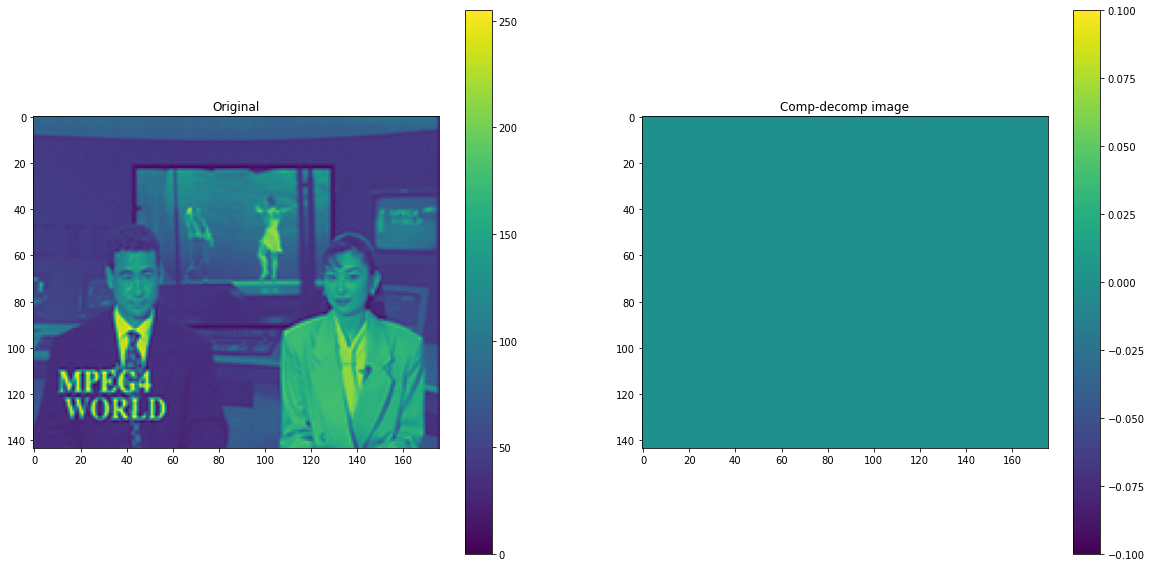

In [6]:
image_id = 1 # Random image from the video
original_img = frames[image_id][:width*height].reshape(height,width)
decompressed_img = decompressed_yuv[image_id][0]


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.colorbar()
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(decompressed_img)
plt.colorbar()
plt.title("Comp-decomp image")
plt.show()

# Compute the number of bps

In [7]:
nb_symbols = frame_size*nb_frames
nb_bit = len(bitstream)
print("B/symb: ", nb_bit/nb_symbols)
print("Original size (MiB): ", nb_symbols/1024**2)
print("Compressed size (MiB): ", nb_bit/8/1024**2)

B/symb:  1.7685523639169471
Original size (MiB):  10.87646484375
Compressed size (MiB):  2.404449701309204
